# Text summarizer in Python, Notes from underground

## Credit: code from https://github.com/louisteo9/personal-text-summarizer

In [30]:
# Natural Language Tool Kit (NLTK)
import nltk
nltk.download('stopwords')

# Regular Expression for text preprocessing
import re

# Heap (priority) queue algorithm to get the top sentences
import heapq

# NumPy for numerical computing
import numpy as np

# pandas for creating DataFrames
import pandas as pd

# matplotlib for plot
from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/gao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load text data

In [31]:
import requests
import re

r = requests.get("https://www.gutenberg.org/cache/epub/600/pg600.txt")
raw_text = r.text
#print(raw_text[0:1000])

In [32]:
# # load text file
# with open('https://raw.githubusercontent.com/davidrkearney/colab-notebooks/main/datasets/NotesfromtheUnderground_Dostoevsky.txt', 'r') as f:
#     file_data = f.read()

In [33]:
# text_file = open("https://raw.githubusercontent.com/davidrkearney/colab-notebooks/main/datasets/NotesfromtheUnderground_Dostoevsky.txt", "r")
#lines = raw_text.readlines()

In [34]:
#lines = raw_text.readlines()

In [35]:
# text_file.close()

In [36]:
# df = pd.read_txt('https://raw.githubusercontent.com/davidrkearney/colab-notebooks/main/datasets/NotesfromtheUnderground_Dostoevsky.txt')

Let's take a look at the text.

In [37]:
# view text data
print(raw_text)

﻿The Project Gutenberg eBook of Notes from the Underground, by Fyodor Dostoyevsky

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Notes from the Underground

Author: Fyodor Dostoyevsky

Translator: Constance Garnett

Release Date: July, 1996 [eBook #600]
[Most recently updated: December 26, 2021]

Language: English


Produced by: Judith Boss. HTML version by Al Haines

*** START OF THE PROJECT GUTENBERG EBOOK NOTES FROM THE UNDERGROUND ***




Notes from the Underground

by Fyodor Dostoyevsky


Contents

 NOTES FROM THE UNDERGROUND

 PART I Underground
 I
 II
 III
 IV
 V
 VI
 VII
 VIII
 IX

## Preprocess text

We use regular expression to do text preprocessing. We will:
1. replace reference number with empty space, if any...
2. replace one or more spaces with single space.

In [38]:
text = raw_text
text = re.sub(r'\[[0-9]*\]',' ',text) # replace reference number i.e. [1], [10], [20] with empty space, if any..
text = re.sub(r'\s+',' ',text) # replace one or more spaces with single space
print(text)

﻿The Project Gutenberg eBook of Notes from the Underground, by Fyodor Dostoyevsky This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. Title: Notes from the Underground Author: Fyodor Dostoyevsky Translator: Constance Garnett Release Date: July, 1996 [eBook #600] [Most recently updated: December 26, 2021] Language: English Produced by: Judith Boss. HTML version by Al Haines *** START OF THE PROJECT GUTENBERG EBOOK NOTES FROM THE UNDERGROUND *** Notes from the Underground by Fyodor Dostoyevsky Contents NOTES FROM THE UNDERGROUND PART I Underground I II III IV V VI VII VIII IX X XI PART II À Propos of the

Next, we form a **clean text** with lower case (without special characters, digits and extra spaces) and split it into individual word, for word score computation and formation of the word histogram. 

The reason to form a clean text is so that the algorithm won't treat, i.e. **"understanding"** and **understanding**, as two different words.

In [39]:
# generate clean text
clean_text = text.lower() # convert all uppercase characters into lowercase characters
clean_text = re.sub(r'\W',' ',clean_text) # replace character other than [a-zA-Z0-9] with empty space
clean_text = re.sub(r'\d',' ',clean_text) # replace digit with empty space
clean_text = re.sub(r'\s+',' ',clean_text) # replace one or more spaces with a single space

print(clean_text)

 the project gutenberg ebook of notes from the underground by fyodor dostoyevsky this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at www gutenberg org if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook title notes from the underground author fyodor dostoyevsky translator constance garnett release date july ebook most recently updated december language english produced by judith boss html version by al haines start of the project gutenberg ebook notes from the underground notes from the underground by fyodor dostoyevsky contents notes from the underground part i underground i ii iii iv v vi vii viii ix x xi part ii à propos of the wet snow i ii iii iv v vi vii viii ix x notes

## Split text into sentences

We split (tokenize) the text into sentences using NLTK **sent_tokenize()** method. We will evaluate the importance of each of sentences, then decide if we should each include in our summary. 

In [40]:
# split (tokenize) the sentences
sentences = nltk.sent_tokenize(text)
print(sentences)

['\ufeffThe Project Gutenberg eBook of Notes from the Underground, by Fyodor Dostoyevsky This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever.', 'You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org.', 'If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook.', 'Title: Notes from the Underground Author: Fyodor Dostoyevsky Translator: Constance Garnett Release Date: July, 1996 [eBook #600] [Most recently updated: December 26, 2021] Language: English Produced by: Judith Boss.', 'HTML version by Al Haines *** START OF THE PROJECT GUTENBERG EBOOK NOTES FROM THE UNDERGROUND *** Notes from the Underground by Fyodor Dostoyevsky Contents NOTES FROM THE UNDERGROUND PART I Underground I II III IV V VI VII VIII IX X XI PART

## Remove stop words

Stop words are English words which do not add much meaning to a sentence. They can be safely ignored without sacrificing the meaning of the sentence. We already downloaded a file with English stop words in the first section of the notebook. 

Here, we will get the list of stop words and store them in **stop_word** variable.

In [41]:
# get stop words list
stop_words = nltk.corpus.stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Build word histogram

Let's evaluate the importance of each word based on how many times it appears in the entire text.

We will do so by 1) splitting the words in **clean_text**, 2) removing the stop words, and then 3) checking the frequency of each word as it appears in the text.

In [42]:
# create an empty dictionary to house the word count
word_count = {}

# loop through tokenized words, remove stop words and save word count to dictionary
for word in nltk.word_tokenize(clean_text):
    # remove stop words
    if word not in stop_words:
        # save word count to dictionary
        if word not in word_count.keys():
            word_count[word] = 1
        else:
            word_count[word] += 1

Let's plot the word histogram and see the results.

In [43]:
# plt.figure(figsize=(16,10))
# plt.xticks(rotation = 90)
# plt.bar(word_count.keys(), word_count.values())
# plt.show()

In [44]:
def plot_top_words(word_count_dict, show_top_n=20):
    word_count_table = pd.DataFrame.from_dict(word_count_dict, orient = 'index').rename(columns={0: 'score'})
    word_count_table.sort_values(by='score').tail(show_top_n).plot(kind='barh', figsize=(10,10))
    plt.show()

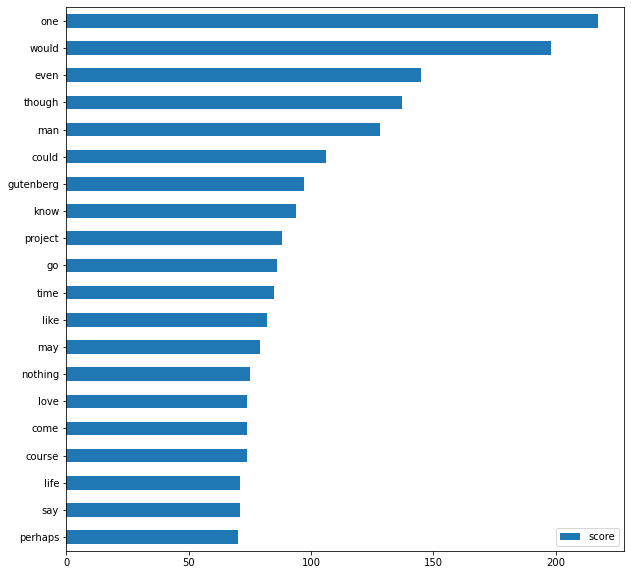

In [45]:
plot_top_words(word_count, 20)

In [46]:
sentence_score = {}

# loop through tokenized sentence, only take sentences that have less than 30 words, then add word score to form sentence score
for sentence in sentences:
    # check if word in sentence is in word_count dictionary
    for word in nltk.word_tokenize(sentence.lower()):
        if word in word_count.keys():
            # only take sentence that has less than 30 words
            if len(sentence.split(' ')) < 30:
                # add word score to sentence score
                if sentence not in sentence_score.keys():
                    sentence_score[sentence] = word_count[word]
                else:
                    sentence_score[sentence] += word_count[word]

In [47]:
df_sentence_score = pd.DataFrame.from_dict(sentence_score, orient = 'index').rename(columns={0: 'score'})
df_sentence_score.sort_values(by='score', ascending = False)

,score
"Perhaps the thing I resented was, that of all your edifices there has not been one at which one could not put out one’s tongue.",914
"You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org.",894
"And no one, no one should know what passes between husband and wife if they love one another.",877
"And one may choose what is contrary to one’s own interests, and sometimes one _positively ought_ (that is my idea).",809
"In fact, I would even have put up with looking base if, at the same time, my face could have been thought strikingly intelligent.",767
...,...
Where are my foundations?,1
That incensed me at once.,1
But here what is there but ... foulness?,1
It was a nightmare.,1


In [48]:
best_sentences = heapq.nlargest(3, sentence_score, key=sentence_score.get)

In [49]:
print('SUMMARY')
print('------------------------')

for sentence in sentences:
    if sentence in best_sentences:
        print (sentence)

SUMMARY
------------------------
You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org.
Perhaps the thing I resented was, that of all your edifices there has not been one at which one could not put out one’s tongue.
And no one, no one should know what passes between husband and wife if they love one another.
You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org.
